<a href="https://colab.research.google.com/github/sayanbanerjee32/coreference-resolution/blob/main/data_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Papers and blogs

End2End Coref Resolution By Attention RNN - https://www.kaggle.com/keyit92/end2end-coref-resolution-by-attention-rnn  
coreference-resolution - https://www.kaggle.com/abhishekbhole/coreference-resolution  
SpanBERT - https://arxiv.org/pdf/1907.10529.pdf   
BERT for Coreference Resolution - https://arxiv.org/pdf/1908.09091.pdf  
GITHub for BERT and SpanBERT - https://github.com/mandarjoshi90/coref  
Fast AI solution - https://www.kaggle.com/mamamot/fastai-awd-lstm-solution-0-71-lb/notebook

In [1]:
%%capture
!pip install fastai -Uq

In [2]:
# mount gdrive for data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# file locations
train_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-development.tsv'
val_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-validate.tsv'
test_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-test.tsv'
model_save_path = '/content/drive/MyDrive/coref_resolution/models/'

In [4]:
import pandas as pd
from fastai.text.all import *
from pathlib import Path
from tqdm.notebook import tqdm

In [5]:
train_df = pd.read_csv(train_file_path,sep="\t")
test_df = pd.read_csv(test_file_path,sep="\t")
val_df = pd.read_csv(val_file_path,sep="\t")

In [6]:
train_df["Text"][0], train_df["Text"][1]

("Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.",
 'He grew up in Evanston, Illinois the second oldest of five children including his brothers, Fred and Gordon and sisters, Marge (Peppy) and Marilyn. His high school days were spent at New Trier High School in Winnetka, Illinois. MacKenzie studied with Bernard Leach from 1949 to 1952. His simple, wheel-thrown functional pottery is heavily influenced by the oriental aesthetic of Shoji Hamada and Kanjiro Kawai.')

In [7]:
print(len(train_df), len(val_df), len(test_df))

2000 454 2000


## Fine tune language model

In [8]:
# lets keep val for final testing
df_pretrain = pd.concat([train_df, test_df])
df_pretrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              4000 non-null   object
 1   Text            4000 non-null   object
 2   Pronoun         4000 non-null   object
 3   Pronoun-offset  4000 non-null   int64 
 4   A               4000 non-null   object
 5   A-offset        4000 non-null   int64 
 6   A-coref         4000 non-null   bool  
 7   B               4000 non-null   object
 8   B-offset        4000 non-null   int64 
 9   B-coref         4000 non-null   bool  
 10  URL             4000 non-null   object
dtypes: bool(2), int64(3), object(6)
memory usage: 320.3+ KB


In [9]:
# fine tune language model
data_lm = DataBlock(
            blocks=TextBlock.from_df('Text', is_lm=True),
            get_x=ColReader('text'),
            splitter=RandomSplitter(0.1))

dls_lm = data_lm.dataloaders(df_pretrain) 
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj michael xxmaj john xxmaj buckley ( born xxmaj june 8 , 1975 ) is an xxmaj american xxmaj internet celebrity , comedian and xxunk . xxmaj noted for his xxunk xxmaj what the xxmaj buck ? ! , xxmaj buckley comments on popular culture events and celebrities . xxbos xxmaj it explored their xxunk and xxunk xxunk , and critically xxunk on the life and teachings of important men from","xxmaj michael xxmaj john xxmaj buckley ( born xxmaj june 8 , 1975 ) is an xxmaj american xxmaj internet celebrity , comedian and xxunk . xxmaj noted for his xxunk xxmaj what the xxmaj buck ? ! , xxmaj buckley comments on popular culture events and celebrities . xxbos xxmaj it explored their xxunk and xxunk xxunk , and critically xxunk on the life and teachings of important men from each"
1,the devil . xxbos xxmaj tears at the prospect of xxunk from the loved one are equally the subject of two xxmaj english paintings inspired by the poem . xxmaj angelica xxmaj xxunk 's xxmaj the xxmaj farewell of xxmaj xxunk and xxmaj xxunk ( 1780 ) pictures an xxunk young xxmaj xxunk in xxmaj xxunk dress xxunk to xxmaj xxunk 's hand as the nuns welcome her at the door of,devil . xxbos xxmaj tears at the prospect of xxunk from the loved one are equally the subject of two xxmaj english paintings inspired by the poem . xxmaj angelica xxmaj xxunk 's xxmaj the xxmaj farewell of xxmaj xxunk and xxmaj xxunk ( 1780 ) pictures an xxunk young xxmaj xxunk in xxmaj xxunk dress xxunk to xxmaj xxunk 's hand as the nuns welcome her at the door of the


In [11]:
# create language model learner
learn_lm = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.5, pretrained=True, 
    metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(valley=0.0030199517495930195)

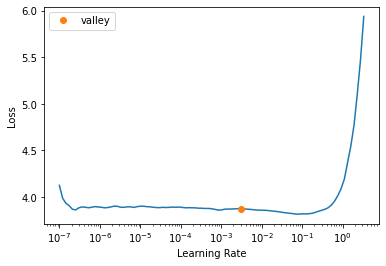

In [12]:
# find optimum learning rate for language model
learn_lm.lr_find()

In [14]:
# one cycle training
learn_lm.fit_one_cycle(1, 0.003)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.404273,3.378016,0.376628,29.312557,00:18


In [15]:
# unfreeze all the layers and one cycle training
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, 0.003)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.229321,3.316282,0.385482,27.557688,00:23
1,3.124325,3.341795,0.382921,28.269838,00:19
2,2.790951,3.410859,0.377539,30.291250,00:19
3,2.367306,3.503397,0.373741,33.228153,00:20
4,2.063835,3.579632,0.370074,35.860336,00:20


In [42]:
# save language model
learn_lm.save(Path(model_save_path) /'lm_fine_tuned')
learn_lm.save_encoder(Path(model_save_path) /'lm_fine_tuned_encoder')

In [22]:
# load pre-trained language model
learn_lm_pretrained = load_learner(Path(model_save_path)/'lm_fine_tuned.pth', cpu = False)

In [41]:
vocab = learn_lm.dls
# vocab.numericalize(tokenizer(train_df["Text"][0]))

TensorText([   2,    8, 1771,    8, 8008,   74,   96,   10,  447,  889, 1772,   13,
           8, 1302,    9,    8, 1958,   11,    8, 6518,   34,    8, 1302,   14,
          10,  175,  314,   13,  104,  155,    9,   39,   24, 8009,   25,    8,
        1536,    9,   12,   33,   52,  648,  184,   11,    8, 8010,    8,  282,
          96,    8, 3467,    8, 5542,    9,    8, 2325,   20,  172,   12,   48,
          16,   93,  483, 3468,   14,    8, 1302,   20,  763,   11,    8, 6518,
          21, 1303,  145,    8, 1302,   20, 1869,   39,   24,   75,  187,   72,
        1607,   25,   21,   41,   66, 4252,   55,   19,  331,   15,   42,    0,
           0,  174,   21,  172,    8, 2325,   11])

## Pre-process data

In [37]:
import torch
from torch.utils.data import Dataset, TensorDataset

In [38]:
spacy_tok = SpacyTokenizer("en")
tokenizer = Tokenizer(spacy_tok)

In [ ]:
# train_df["Text"][0], tokenizer(train_df["Text"][0])

In [55]:
import spacy
nlp = spacy.blank("en")

def get_token_num_by_offset(s, offset):
  s_pre = s[:offset]
  return len(tokenizer(s_pre))

# note that 'xxunk' is not special in this sense
special_tokens = ['xxbos','xxfld','xxpad', 'xxmaj','xxup','xxrep','xxwrep']


def adjust_token_num(processed, token_num):
  """
  As fastai tokenizer introduces additional tokens, we need to adjust for them.
  """
  counter = -1
  do_unrep = None
  for i, token in enumerate(processed):
    if token not in special_tokens:
      counter += 1
    if do_unrep:
      do_unrep = False
      if processed[i+1] != ".":
        token_num -= (int(token) - 2) # one to account for the num itself
      else:  # spacy doesn't split full stops
        token_num += 1
    if token == "xxrep":
      do_unrep = True
    if counter == token_num:
      return i
  else:
    counter = -1
    for i, t in enumerate(processed):
      if t not in special_tokens:
        counter += 1
      # print(i, counter, t)
    raise Exception(f"{token_num} is out of bounds ({processed})")

In [49]:
def dataframe_to_tensors(df, max_len=512):
  # offsets are: pron_tok_offset, a_tok_offset, a_tok_right_offset, b_tok_offset, b_tok_right_offset
  offsets = list()
  labels = np.zeros((len(df),), dtype=np.int64)
  processed = list()
  for i, row in tqdm(df.iterrows()):
    try:
      text = row["Text"]
      a_offset = row["A-offset"]
      a_len = len(nlp(row["A"]))
      
      b_offset = row["B-offset"]
      b_len = len(nlp(row["B"]))

      pron_offset = row["Pronoun-offset"]
      is_a = row["A-coref"]
      is_b = row["B-coref"]
      a_tok_offset = get_token_num_by_offset(text, a_offset)
      b_tok_offset = get_token_num_by_offset(text, b_offset)
      a_right_offset = a_tok_offset + a_len - 1
      b_right_offset = b_tok_offset + b_len - 1
      pron_tok_offset = get_token_num_by_offset(text, pron_offset)
      tokenized = tokenizer(text)[:max_len]
      tokenized = tokenized  + ["xxpad"] * (max_len - len(tokenized)) # add padding
      a_tok_offset = adjust_token_num(tokenized, a_tok_offset)
      a_tok_right_offset = adjust_token_num(tokenized, a_right_offset)
      b_tok_offset = adjust_token_num(tokenized, b_tok_offset)
      b_tok_right_offset = adjust_token_num(tokenized, b_right_offset)
      pron_tok_offset = adjust_token_num(tokenized, pron_tok_offset)
      numericalized = vocab.numericalize(tokenized)
      processed.append(torch.tensor(numericalized, dtype=torch.long))
      offsets.append([pron_tok_offset, a_tok_offset, a_tok_right_offset, b_tok_offset, b_tok_right_offset])
      if is_a:
        labels[i] = 0
      elif is_b:
        labels[i] = 1
      else:
        labels[i] = 2
    except Exception as e:
      print(i)
      raise
  processed = torch.stack(processed)
  offsets = torch.tensor(offsets, dtype=torch.long)
  labels = torch.from_numpy(labels)
  return processed, offsets, labels

In [56]:
train_ds = TensorDataset(*dataframe_to_tensors(train_df))
valid_ds = TensorDataset(*dataframe_to_tensors(val_df))
test_ds = TensorDataset(*dataframe_to_tensors(test_df))

0it [00:00, ?it/s]

3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Exception: ignored

In [ ]:
dls_lm